<a href="https://colab.research.google.com/github/zuobinxiong/CS789/blob/main/Lab7_MI_Attack_and_Stealing_Attack_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# download dataset link: https://drive.google.com/file/d/14kYe09TjIyb9HoRC5ySfgLKiaJ_DT01k/view?usp=sharing

In [ ]:
!unzip /content/ModelInversion.zip

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets


# 1 Model Inversion Attack

In [ ]:
# set seeds
SEED = 12
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# torch.backends.cudnn.deterministic = True

In [ ]:
# transfrom, wee need grayscale to convert the images to 1 channel
transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
# load dataset
atnt_faces = ...

In [ ]:
# split dataset: 3 images of every class as validation set
i = [i for i in range(len(atnt_faces)) if i % 10 > 3]
i_val = [i for i in range(len(atnt_faces)) if i % 10 <= 3]

# load data
BATCH_SIZE = 64
train_dataset = torch.utils.data.Subset(atnt_faces, i)
train_data_loader = data.DataLoader(train_dataset,
                                    shuffle=True,
                                    batch_size=BATCH_SIZE)

validation_dataset = torch.utils.data.Subset(atnt_faces, i_val)
validation_data_loader = data.DataLoader(validation_dataset,
                                          batch_size=BATCH_SIZE)

In [ ]:
# create the target model as the attacker's object
class TargetModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 3000)
        self.output_fc = nn.Linear(3000, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h = torch.sigmoid(self.input_fc(x))
        output = self.output_fc(h)

        return output, h

In [ ]:
# define dimensions
INPUT_DIM = 112 * 92
OUTPUT_DIM = 40

# create model
mlp = ...

In [ ]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s' % device)
mlp = mlp.to(device)

Using device: cuda


In [ ]:
# calculating accuracy
def calculate_accuracy(y_pred, y):
    top_pred = ...
    correct = ...
    acc = ...
    return acc

In [ ]:
def train(mlp, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    mlp.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = mlp(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(mlp, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    mlp.eval()

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = mlp(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def train_target_model(epochs):
    # set criterion and optimizer
    criterion = ...
    # criterion
    optimizer = ...

    best_valid_loss = float('inf')

    print('---Target Model Training Started---')
    for epoch in range(epochs):
        # train algorithm
        train_loss, train_acc = ...
        # evaluate algorithm
        valid_loss, valid_acc = ...

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss

        print(f'Epoch: {epoch + 1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

    torch.save(mlp.state_dict(), 'atnt-mlp-model.pth')
    print('---Target Model Training Done---')

In [ ]:
train_target_model(20)

---Target Model Training Started---
Epoch: 01
	Train Loss: 4.447 | Train Acc: 13.15%
	 Val. Loss: 2.353 |  Val. Acc: 44.27%
Epoch: 02
	Train Loss: 1.863 | Train Acc: 62.11%
	 Val. Loss: 1.898 |  Val. Acc: 45.31%
Epoch: 03
	Train Loss: 1.113 | Train Acc: 76.82%
	 Val. Loss: 1.088 |  Val. Acc: 83.85%
Epoch: 04
	Train Loss: 0.500 | Train Acc: 97.92%
	 Val. Loss: 0.740 |  Val. Acc: 90.62%
Epoch: 05
	Train Loss: 0.264 | Train Acc: 99.61%
	 Val. Loss: 0.554 |  Val. Acc: 92.71%
Epoch: 06
	Train Loss: 0.137 | Train Acc: 100.00%
	 Val. Loss: 0.450 |  Val. Acc: 94.27%
Epoch: 07
	Train Loss: 0.079 | Train Acc: 100.00%
	 Val. Loss: 0.380 |  Val. Acc: 95.31%
Epoch: 08
	Train Loss: 0.050 | Train Acc: 100.00%
	 Val. Loss: 0.321 |  Val. Acc: 94.79%
Epoch: 09
	Train Loss: 0.032 | Train Acc: 100.00%
	 Val. Loss: 0.277 |  Val. Acc: 95.31%
Epoch: 10
	Train Loss: 0.022 | Train Acc: 100.00%
	 Val. Loss: 0.244 |  Val. Acc: 95.31%
Epoch: 11
	Train Loss: 0.017 | Train Acc: 100.00%
	 Val. Loss: 0.225 |  Val. Ac

# Starting Model Inversion Attack

In [ ]:
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# from target_model import TargetModel, train_target_model

import argparse

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s' % device)
# define dimensions
INPUT_DIM = 112 * 92
OUTPUT_DIM = 40

Using device: cuda


In [ ]:
def mi_face(label_index, model, num_iterations, gradient_step, loss_function):
    model.to(device)
    model.eval()

    # initialize two 112 * 92 tensors with zeros
    tensor = ...
    image = ...

    # initialize with infinity
    min_loss = float("inf")

    for i in range(num_iterations):
        tensor.requires_grad = True

        # get the prediction probs
        pred, _ = ...

        # calculate the loss and gardient for the class we want to reconstruct
        if loss_function == "crossEntropy":
            # use this
            crit = ...
            loss = ...
        else:
            # or this
            soft_pred = nn.functional.softmax(pred, 1)
            loss = soft_pred.squeeze()[label_index]
        print('Loss: ' + str(loss.item()))

        loss.backward()

        with torch.no_grad():
            # apply gradient descent
            tensor = ...

        # set image = tensor only if the new loss is the min from all iterations
        if loss < min_loss:
            min_loss = ...
            image = ...

    return image

In [ ]:
def perform_pretrained_dummy(iterations, loss_function, generate_specific_class):
    # find the path of the stored model parameters
    data_path = ...
    # create a target model structure to attack
    model = ...
    # load the trained model parameter to the targetmodel structure
    model....

    if generate_specific_class == -1:
        print('\nStart model inversion for all classes\n')
        perform_attack_and_print_all_results(model, iterations, loss_function)
    else:
        print('\nstart model inversion for class ' + str(generate_specific_class) + '\n')
        perform_attack_and_print_one_result(model, iterations, loss_function, generate_specific_class)

In [ ]:
def perform_attack_and_print_all_results(model, iterations, loss_function):

    gradient_step_size = 0.1

    # print all pictures
    # create figure
    fig, axs = plt.subplots(8, 10)
    fig.set_size_inches(20, 24)
    random.seed(7)
    count = 0
    for i in range(0, 8, 2):
        for j in range(10):
            # get random validation set image from respective class
            count += 1
            print('\nReconstructing Class ' + str(count))

            ran = random.randint(1, 2)
            path = 'ModelInversion/data_pgm/s0' + str(count) + '/' + str(
                ran) + '.pgm' if count < 10 else 'ModelInversion/data_pgm/s' + str(count) + '/' + str(ran) + '.pgm'

            with open(path, 'rb') as f:
                original = plt.imread(f)

            # reconstruct respective class
            reconstruction = mi_face(count - 1, model, iterations, gradient_step_size, loss_function)

            # add both images to the plot
            axs[i, j].imshow(original, cmap='gray')
            axs[i + 1, j].imshow(reconstruction.squeeze().detach().numpy(), cmap='gray')
            axs[i, j].axis('off')
            axs[i + 1, j].axis('off')

    # plot reconstructed image
    fig.suptitle('Images reconstructed with ' + str(
        iterations) + ' iterations of mi_face. Find the reconstruction below each row with train set samples.',
                 fontsize=20)
    fig.savefig('ModelInversion/results/results_' + str(iterations) + '.png', dpi=100)
    plt.show()
    print('\nReconstruction Results can be found in results folder')

In [ ]:
def perform_attack_and_print_one_result (model,  iterations, loss_function, generate_specific_class):
    # set params
    gradient_step_size = 0.1

    # create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, sharey=True)
    # reconstruction for class 0
    reconstruction = mi_face(generate_specific_class-1, model, iterations, gradient_step_size, loss_function)
    ran = random.randint(1, 2)
    path = 'ModelInversion/data_pgm/s0' + str(generate_specific_class) + '/' + str(
        ran) + '.pgm' if generate_specific_class < 10 else 'ModelInversion/data_pgm/s' + str(generate_specific_class) + '/' + str(ran) + '.pgm'

    with open(path, 'rb') as f:
        original = plt.imread(f)
    # add both images to the plot
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Sample train set image')
    ax1.axis('off')
    ax2.imshow(reconstruction.squeeze().detach().numpy(), cmap='gray')
    ax2.set_title('Reconstructed image')
    ax2.axis('off')

    # plot reconstructed image
    fig.suptitle('Images reconstructed with\n ' + str(
        iterations) + ' iterations of mi_face. ', fontsize=15)
    fig.savefig('ModelInversion/results/results_' + str(iterations) + '.png', dpi=100)
    plt.show()
    print('Reconstruction Results can be found in results folder')

In [ ]:
# test different attacks
perform_pretrained_dummy(...)

## Model Extraction Attack (with ART tool)

In [ ]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Flatten, InputLayer, Reshape

from art.estimators.classification import KerasClassifier

tf.compat.v1.disable_eager_execution()

In [ ]:
import art
from art.utils import load_mnist

# Load the dataset, and split the test data into test and steal datasets.
(x_train, y_train), (x_test0, y_test0), _, _ = load_mnist()
len_steal = 5000
indices = np.random.permutation(len(x_test0))
# split the test data into test and steal datasets.
x_steal = ...
y_steal =...
x_test = ...
y_test = ...

im_shape = x_train[0].shape

# define the target model structure
def get_model(num_classes=10, c1=32, c2=64, d1=128):
    model = Sequential()
    model.add(Conv2D(c1, kernel_size=(3, 3), activation='relu', input_shape=im_shape))
    model.add(Conv2D(c2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(d1, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer="sgd",
                          metrics=['accuracy'])
    return model

In [ ]:
# Train the original model.
num_epochs = 5
# get the model for training
model = ...
print("Original model training:")
# train the model with training dataset
model....
print("Original model evaluation:")
# evaluate the model with testing dataset
print(model....)
classifier_original = KerasClassifier(model, clip_values=(0, 1), use_logits=False)

Original model training:
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 168us/sample - loss: 0.6029 - accuracy: 0.8399
Epoch 2/5
60000/60000 [==============================] - 3s 56us/sample - loss: 0.2392 - accuracy: 0.9286
Epoch 3/5
60000/60000 [==============================] - 3s 55us/sample - loss: 0.1830 - accuracy: 0.9454
Epoch 4/5
60000/60000 [==============================] - 4s 60us/sample - loss: 0.1494 - accuracy: 0.9547
Epoch 5/5
60000/60000 [==============================] - 4s 61us/sample - loss: 0.1282 - accuracy: 0.9614
Original model evaluation:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[0.1169010284371674, 0.9652]


In [ ]:
# Stealing from the unprotected classifier.
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets

attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

results = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
        # build a classifier with KerasClassifier
        classifier_stolen = ...
        # use attack.extract to perform attack
        classifier_stolen = ...
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 250 samples
Epoch 1/5
250/250 [==============================] - 0s 1ms/sample - loss: 2.2789 - accuracy: 0.1520
Epoch 2/5
250/250 [==============================] - 0s 129us/sample - loss: 2.2568 - accuracy: 0.2640
Epoch 3/5
250/250 [==============================] - 0s 101us/sample - loss: 2.2338 - accuracy: 0.4560
Epoch 4/5
250/250 [==============================] - 0s 106us/sample - loss: 2.2101 - accuracy: 0.5560
Epoch 5/5
250/250 [==============================] - 0s 98us/sample - loss: 2.1828 - accuracy: 0.6200
Probabilistic CopycatCNN : 0.53979486


Train on 250 samples
Epoch 1/5
250/250 [==============================] - 0s 291us/sample - loss: 2.3079 - accuracy: 0.0920
Epoch 2/5
250/250 [==============================] - 0s 95us/sample - loss: 2.2919 - accuracy: 0.1200
Epoch 3/5
250/250 [==============================] - 0s 85us/sample - loss: 2.2755 - accuracy: 0.1400
Epoch 4/5
250/250 [==============================] - 0s 86us/sample - loss: 2.2599 - accuracy: 0.1800
Epoch 5/5
250/250 [==============================] - 0s 83us/sample - loss: 2.2434 - accuracy: 0.2080


Argmax CopycatCNN : 0.25815386


Probabilistic KnockoffNets : 0.33394873


Argmax KnockoffNets : 0.20902564
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 0s 454us/sample - loss: 2.2972 - accuracy: 0.1220
Epoch 2/5
500/500 [==============================] - 0s 90us/sample - loss: 2.2554 - accuracy: 0.1220
Epoch 3/5
500/500 [==============================] - 0s 83us/sample - loss: 2.2106 - accuracy: 0.1800
Epoch 4/5
500/500 [==============================] - 0s 79us/sample - loss: 2.1566 - accuracy: 0.2240
Epoch 5/5
500/500 [==============================] - 0s 78us/sample - loss: 2.0861 - accuracy: 0.3880


Probabilistic CopycatCNN : 0.4303158
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 0s 229us/sample - loss: 2.3087 - accuracy: 0.0920
Epoch 2/5
500/500 [==============================] - 0s 83us/sample - loss: 2.2909 - accuracy: 0.1480
Epoch 3/5
500/500 [==============================] - 0s 80us/sample - loss: 2.2733 - accuracy: 0.2500
Epoch 4/5
500/500 [==============================] - 0s 79us/sample - loss: 2.2550 - accuracy: 0.3280
Epoch 5/5
500/500 [==============================] - 0s 76us/sample - loss: 2.2344 - accuracy: 0.3860


Argmax CopycatCNN : 0.36178946


Probabilistic KnockoffNets : 0.4711579
Argmax KnockoffNets : 0.37894738


Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 0s 327us/sample - loss: 2.2836 - accuracy: 0.1750
Epoch 2/5
1000/1000 [==============================] - 0s 95us/sample - loss: 2.2401 - accuracy: 0.3580
Epoch 3/5
1000/1000 [==============================] - 0s 89us/sample - loss: 2.1765 - accuracy: 0.5180
Epoch 4/5
1000/1000 [==============================] - 0s 83us/sample - loss: 2.0675 - accuracy: 0.6260
Epoch 5/5
1000/1000 [==============================] - 0s 81us/sample - loss: 1.8656 - accuracy: 0.6580
Probabilistic CopycatCNN : 0.7138889


Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 0s 223us/sample - loss: 2.2716 - accuracy: 0.2330
Epoch 2/5
1000/1000 [==============================] - 0s 109us/sample - loss: 2.1966 - accuracy: 0.3750
Epoch 3/5
1000/1000 [==============================] - 0s 109us/sample - loss: 2.0816 - accuracy: 0.5680
Epoch 4/5
1000/1000 [==============================] - 0s 106us/sample - loss: 1.8628 - accuracy: 0.6330
Epoch 5/5
1000/1000 [==============================] - 0s 96us/sample - loss: 1.4578 - accuracy: 0.7710


Argmax CopycatCNN : 0.74377775


Probabilistic KnockoffNets : 0.73355556


Argmax KnockoffNets : 0.73066664
Train on 2000 samples
Epoch 1/5
2000/2000 [==============================] - 0s 147us/sample - loss: 2.2682 - accuracy: 0.2805
Epoch 2/5
2000/2000 [==============================] - 0s 75us/sample - loss: 2.1368 - accuracy: 0.5765
Epoch 3/5
2000/2000 [==============================] - 0s 69us/sample - loss: 1.7202 - accuracy: 0.7030
Epoch 4/5
2000/2000 [==============================] - 0s 68us/sample - loss: 0.9556 - accuracy: 0.7955
Epoch 5/5
2000/2000 [==============================] - 0s 71us/sample - loss: 0.5930 - accuracy: 0.8555


Probabilistic CopycatCNN : 0.782875
Train on 2000 samples
Epoch 1/5
2000/2000 [==============================] - 0s 117us/sample - loss: 2.2880 - accuracy: 0.1290
Epoch 2/5
2000/2000 [==============================] - 0s 69us/sample - loss: 2.2339 - accuracy: 0.3755
Epoch 3/5
2000/2000 [==============================] - 0s 67us/sample - loss: 2.1078 - accuracy: 0.5390
Epoch 4/5
2000/2000 [==============================] - 0s 68us/sample - loss: 1.6802 - accuracy: 0.7235
Epoch 5/5
2000/2000 [==============================] - 0s 70us/sample - loss: 0.8907 - accuracy: 0.8160


Argmax CopycatCNN : 0.794375


Probabilistic KnockoffNets : 0.853125
Argmax KnockoffNets : 0.7985


Train on 4000 samples
Epoch 1/5
4000/4000 [==============================] - 1s 131us/sample - loss: 2.1940 - accuracy: 0.3573
Epoch 2/5
4000/4000 [==============================] - 0s 73us/sample - loss: 1.3099 - accuracy: 0.7610
Epoch 3/5
4000/4000 [==============================] - 0s 68us/sample - loss: 0.5041 - accuracy: 0.8748
Epoch 4/5
4000/4000 [==============================] - 0s 67us/sample - loss: 0.3715 - accuracy: 0.9015
Epoch 5/5
4000/4000 [==============================] - 0s 68us/sample - loss: 0.3261 - accuracy: 0.9125


Probabilistic CopycatCNN : 0.90133333
Train on 4000 samples
Epoch 1/5
4000/4000 [==============================] - 0s 108us/sample - loss: 2.1917 - accuracy: 0.3528
Epoch 2/5
4000/4000 [==============================] - 0s 76us/sample - loss: 1.2857 - accuracy: 0.7380
Epoch 3/5
4000/4000 [==============================] - 0s 70us/sample - loss: 0.4918 - accuracy: 0.8595
Epoch 4/5
4000/4000 [==============================] - 0s 68us/sample - loss: 0.3465 - accuracy: 0.8907
Epoch 5/5
4000/4000 [==============================] - 0s 74us/sample - loss: 0.2896 - accuracy: 0.9047


Argmax CopycatCNN : 0.8655


Probabilistic KnockoffNets : 0.88666666
Argmax KnockoffNets : 0.9015


Train on 5000 samples
Epoch 1/5
5000/5000 [==============================] - 1s 117us/sample - loss: 2.2114 - accuracy: 0.4366
Epoch 2/5
5000/5000 [==============================] - 0s 74us/sample - loss: 1.2721 - accuracy: 0.7518
Epoch 3/5
5000/5000 [==============================] - 0s 70us/sample - loss: 0.4709 - accuracy: 0.8752
Epoch 4/5
5000/5000 [==============================] - 0s 69us/sample - loss: 0.3714 - accuracy: 0.8954
Epoch 5/5
5000/5000 [==============================] - 0s 72us/sample - loss: 0.3214 - accuracy: 0.9150


Probabilistic CopycatCNN : 0.8852
Train on 5000 samples
Epoch 1/5
5000/5000 [==============================] - 1s 104us/sample - loss: 2.0573 - accuracy: 0.5080
Epoch 2/5
5000/5000 [==============================] - 0s 75us/sample - loss: 0.7453 - accuracy: 0.8276
Epoch 3/5
5000/5000 [==============================] - 0s 69us/sample - loss: 0.3673 - accuracy: 0.8896
Epoch 4/5
5000/5000 [==============================] - 0s 69us/sample - loss: 0.2957 - accuracy: 0.9042
Epoch 5/5
5000/5000 [==============================] - 0s 72us/sample - loss: 0.2702 - accuracy: 0.9186


Argmax CopycatCNN : 0.8636
Probabilistic KnockoffNets : 0.8188


Argmax KnockoffNets : 0.745


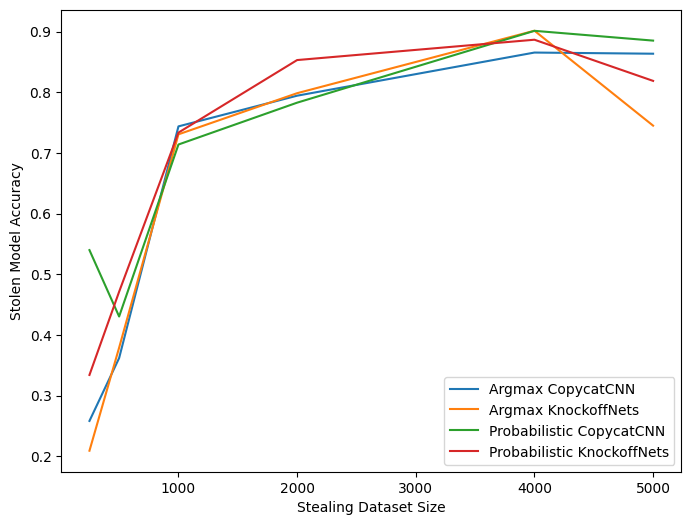

In [ ]:
import pandas as pd
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

In [ ]:
# Prepare the defense layer.
from art.defences.postprocessor import ReverseSigmoid
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2)
classifier_protected = KerasClassifier(model, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

# Below is used by `FunctionallyEquivalentExtraction`.
model_flat = Sequential([InputLayer([784]), Reshape([28, 28, 1]), model])
model_flat.compile('sgd', 'categorical_crossentropy', ['accuracy'])
classifier_flat_protected = KerasClassifier(model_flat, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

In [ ]:
# Prepare the defense layer.
from art.defences.postprocessor import Rounded
postprocessor = Rounded(decimals=1)
classifier_protected = KerasClassifier(model, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

In [ ]:
# Stealing from the protected classifier.

attack_catalogue = {
                    "Probabilistic CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
#                     "FunctionallyEquivalentExtraction": FunctionallyEquivalentExtraction(classifier=classifier_flat_protected,
#                                               num_neurons=128),  # This one takes too long time for this dataset/model.
                    }

results_protected = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        if name=="FunctionallyEquivalentExtraction":
            classifier_stolen = attack.extract(np.reshape(x_steal, [len(x_steal), -1]), y_steal, thieved_classifier=classifier_stolen)
        else:
            classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)

        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results_protected.append((name, len_steal, acc))

Train on 250 samples
Epoch 1/5
250/250 [==============================] - 1s 6ms/sample - loss: 2.2927 - accuracy: 0.0960
Epoch 2/5
250/250 [==============================] - 0s 255us/sample - loss: 2.2841 - accuracy: 0.1520
Epoch 3/5
250/250 [==============================] - 0s 230us/sample - loss: 2.2752 - accuracy: 0.2040
Epoch 4/5
250/250 [==============================] - 0s 256us/sample - loss: 2.2662 - accuracy: 0.2400
Epoch 5/5
250/250 [==============================] - 0s 246us/sample - loss: 2.2571 - accuracy: 0.2640


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Probabilistic CopycatCNN (vs. Protected) : 0.22892308
Train on 250 samples
Epoch 1/5
250/250 [==============================] - 1s 2ms/sample - loss: 2.3035 - accuracy: 0.1040
Epoch 2/5
250/250 [==============================] - 0s 115us/sample - loss: 2.2957 - accuracy: 0.1280
Epoch 3/5
250/250 [==============================] - 0s 121us/sample - loss: 2.2879 - accuracy: 0.1440
Epoch 4/5
250/250 [==============================] - 0s 117us/sample - loss: 2.2798 - accuracy: 0.1520
Epoch 5/5
250/250 [==============================] - 0s 136us/sample - loss: 2.2716 - accuracy: 0.1560


Argmax CopycatCNN (vs. Protected) : 0.11364102


Probabilistic KnockoffNets (vs. Protected) : 0.236
Argmax KnockoffNets (vs. Protected) : 0.2708718


Train on 500 samples
Epoch 1/5
500/500 [==============================] - 1s 2ms/sample - loss: 2.2861 - accuracy: 0.1040
Epoch 2/5
500/500 [==============================] - 0s 160us/sample - loss: 2.2615 - accuracy: 0.2880
Epoch 3/5
500/500 [==============================] - 0s 140us/sample - loss: 2.2363 - accuracy: 0.3680
Epoch 4/5
500/500 [==============================] - 0s 134us/sample - loss: 2.2075 - accuracy: 0.4380
Epoch 5/5
500/500 [==============================] - 0s 140us/sample - loss: 2.1726 - accuracy: 0.4860


Probabilistic CopycatCNN (vs. Protected) : 0.46557894
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 1s 2ms/sample - loss: 2.2900 - accuracy: 0.1880
Epoch 2/5
500/500 [==============================] - 0s 144us/sample - loss: 2.2641 - accuracy: 0.3000
Epoch 3/5
500/500 [==============================] - 0s 154us/sample - loss: 2.2362 - accuracy: 0.3360
Epoch 4/5
500/500 [==============================] - 0s 147us/sample - loss: 2.2018 - accuracy: 0.3760
Epoch 5/5
500/500 [==============================] - 0s 150us/sample - loss: 2.1574 - accuracy: 0.4080


Argmax CopycatCNN (vs. Protected) : 0.4234737


Probabilistic KnockoffNets (vs. Protected) : 0.43757895
Argmax KnockoffNets (vs. Protected) : 0.4976842


Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 1s 708us/sample - loss: 2.2817 - accuracy: 0.1170
Epoch 2/5
1000/1000 [==============================] - 0s 106us/sample - loss: 2.2464 - accuracy: 0.3130
Epoch 3/5
1000/1000 [==============================] - 0s 110us/sample - loss: 2.2016 - accuracy: 0.4440
Epoch 4/5
1000/1000 [==============================] - 0s 105us/sample - loss: 2.1307 - accuracy: 0.5060
Epoch 5/5
1000/1000 [==============================] - 0s 106us/sample - loss: 2.0066 - accuracy: 0.5830
Probabilistic CopycatCNN (vs. Protected) : 0.59555554


Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 1s 696us/sample - loss: 2.2820 - accuracy: 0.1640
Epoch 2/5
1000/1000 [==============================] - 0s 114us/sample - loss: 2.2348 - accuracy: 0.3270
Epoch 3/5
1000/1000 [==============================] - 0s 106us/sample - loss: 2.1717 - accuracy: 0.4680
Epoch 4/5
1000/1000 [==============================] - 0s 120us/sample - loss: 2.0657 - accuracy: 0.5650
Epoch 5/5
1000/1000 [==============================] - 0s 105us/sample - loss: 1.8660 - accuracy: 0.6730
Argmax CopycatCNN (vs. Protected) : 0.69277775


Probabilistic KnockoffNets (vs. Protected) : 0.5571111


Argmax KnockoffNets (vs. Protected) : 0.64255553


Train on 2000 samples
Epoch 1/5
2000/2000 [==============================] - 1s 417us/sample - loss: 2.2515 - accuracy: 0.2095
Epoch 2/5
2000/2000 [==============================] - 0s 105us/sample - loss: 2.1148 - accuracy: 0.4435
Epoch 3/5
2000/2000 [==============================] - 0s 103us/sample - loss: 1.6959 - accuracy: 0.6220
Epoch 4/5
2000/2000 [==============================] - 0s 100us/sample - loss: 0.9355 - accuracy: 0.8025
Epoch 5/5
2000/2000 [==============================] - 0s 107us/sample - loss: 0.5588 - accuracy: 0.8580
Probabilistic CopycatCNN (vs. Protected) : 0.76075


Train on 2000 samples
Epoch 1/5
2000/2000 [==============================] - 1s 573us/sample - loss: 2.2642 - accuracy: 0.1905
Epoch 2/5
2000/2000 [==============================] - 0s 138us/sample - loss: 2.1002 - accuracy: 0.4585
Epoch 3/5
2000/2000 [==============================] - 0s 144us/sample - loss: 1.5705 - accuracy: 0.7010
Epoch 4/5
2000/2000 [==============================] - 0s 136us/sample - loss: 0.8198 - accuracy: 0.8040
Epoch 5/5
2000/2000 [==============================] - 0s 135us/sample - loss: 0.5096 - accuracy: 0.8585


Argmax CopycatCNN (vs. Protected) : 0.856875


Probabilistic KnockoffNets (vs. Protected) : 0.858625


Argmax KnockoffNets (vs. Protected) : 0.8365
Train on 4000 samples
Epoch 1/5
4000/4000 [==============================] - 1s 267us/sample - loss: 2.1565 - accuracy: 0.4087
Epoch 2/5
4000/4000 [==============================] - 0s 102us/sample - loss: 1.1425 - accuracy: 0.7793
Epoch 3/5
4000/4000 [==============================] - 0s 97us/sample - loss: 0.4622 - accuracy: 0.8727
Epoch 4/5
4000/4000 [==============================] - 0s 95us/sample - loss: 0.3544 - accuracy: 0.8980
Epoch 5/5
4000/4000 [==============================] - 0s 94us/sample - loss: 0.3208 - accuracy: 0.9100
Probabilistic CopycatCNN (vs. Protected) : 0.8983333


Train on 4000 samples
Epoch 1/5
4000/4000 [==============================] - 1s 265us/sample - loss: 2.1076 - accuracy: 0.4232
Epoch 2/5
4000/4000 [==============================] - 0s 97us/sample - loss: 0.9900 - accuracy: 0.7952
Epoch 3/5
4000/4000 [==============================] - 0s 96us/sample - loss: 0.4353 - accuracy: 0.8750
Epoch 4/5
4000/4000 [==============================] - 0s 93us/sample - loss: 0.3448 - accuracy: 0.8898
Epoch 5/5
4000/4000 [==============================] - 0s 91us/sample - loss: 0.2864 - accuracy: 0.9085


Argmax CopycatCNN (vs. Protected) : 0.9066667
Probabilistic KnockoffNets (vs. Protected) : 0.90133333


Argmax KnockoffNets (vs. Protected) : 0.76783335


Train on 5000 samples
Epoch 1/5
5000/5000 [==============================] - 1s 275us/sample - loss: 2.0830 - accuracy: 0.4216
Epoch 2/5
5000/5000 [==============================] - 1s 137us/sample - loss: 0.8021 - accuracy: 0.8220
Epoch 3/5
5000/5000 [==============================] - 1s 135us/sample - loss: 0.3868 - accuracy: 0.8896
Epoch 4/5
5000/5000 [==============================] - 1s 132us/sample - loss: 0.3159 - accuracy: 0.9100
Epoch 5/5
5000/5000 [==============================] - 1s 127us/sample - loss: 0.2919 - accuracy: 0.9152


Probabilistic CopycatCNN (vs. Protected) : 0.8992
Train on 5000 samples
Epoch 1/5
5000/5000 [==============================] - 2s 337us/sample - loss: 2.0129 - accuracy: 0.4662
Epoch 2/5
5000/5000 [==============================] - 1s 106us/sample - loss: 0.6506 - accuracy: 0.8416
Epoch 3/5
5000/5000 [==============================] - 0s 98us/sample - loss: 0.3459 - accuracy: 0.8896
Epoch 4/5
5000/5000 [==============================] - 0s 97us/sample - loss: 0.2922 - accuracy: 0.9012
Epoch 5/5
5000/5000 [==============================] - 0s 94us/sample - loss: 0.2513 - accuracy: 0.9176


Argmax CopycatCNN (vs. Protected) : 0.6284


Probabilistic KnockoffNets (vs. Protected) : 0.8876
Argmax KnockoffNets (vs. Protected) : 0.7412


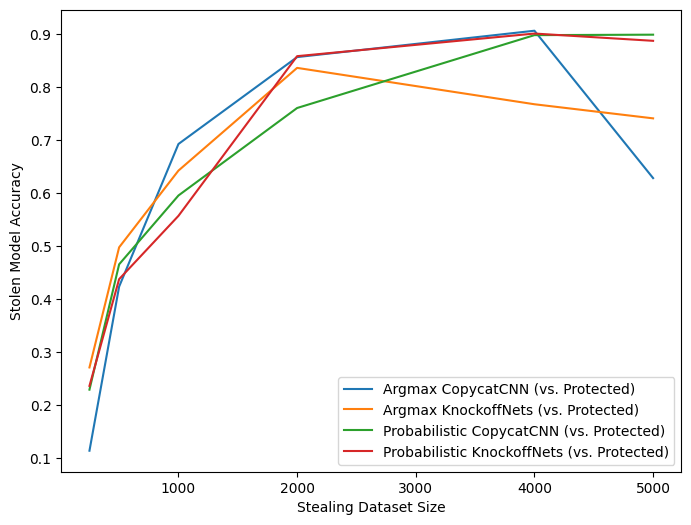

In [ ]:
import pandas as pd
df_protected = pd.DataFrame(results_protected, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df_protected.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

In [ ]:
df_combined = pd.concat([df, df_protected])
groupby = df_combined.groupby("Method Name")

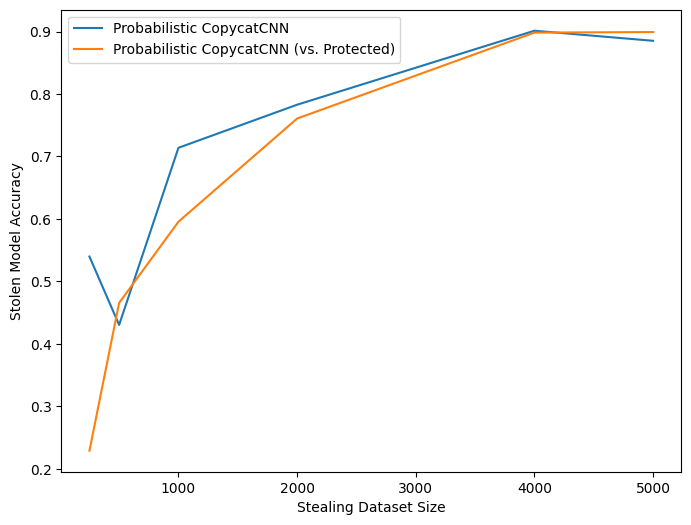

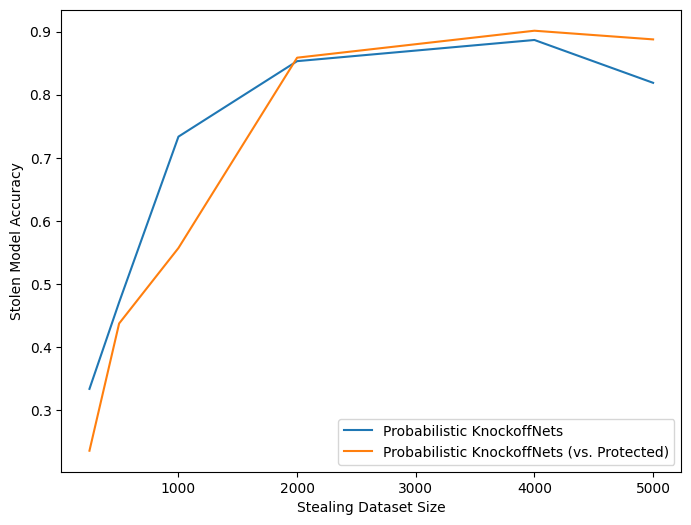

In [ ]:
names = ["CopycatCNN", "KnockoffNets"]
for name in names:
    fig, ax = plt.subplots(figsize=(8,6))
    groupby.get_group("Probabilistic " + name).plot(1,2,ax=ax, label="Probabilistic " + name)
    groupby.get_group("Probabilistic " + name + " (vs. Protected)").plot(1,2,ax=ax, label="Probabilistic " + name + " (vs. Protected)")
    ax.set_xlabel("Stealing Dataset Size")
    ax.set_ylabel("Stolen Model Accuracy")
    fig.show()